# Clasificación de futbolistas mediante regresión logística

En la continuidad de mi trabajo sobre la caracterización de los jugadores de fútbol, esta vez he utilizado
el algoritmo de clasificación supervisada de regresión logística. Para separar a mis jugadores en diferentes clases, he utilizado mi clasificazion hecha con el trabajo de clustering (1 cluster = 1 clase). Entonces, mis datos (ver archivo "k_means_clusters.csv") se componen de 52 features (goals, bigChancesCreated, asssists ...) y de 9 clases (cada una representando un tipo de jugador).



In [ ]:
from itertools import cycle
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import numpy as np

df = pd.read_csv('k_means_clusters.csv', index_col='name')

x = df.drop('cluster', axis=1)
y = df.loc[:, 'cluster']

# print some of the 52 features
print('data:\n')
print(df[['goals', 'bigChancesCreated', 'bigChancesMissed', 'assists']])

# print targets
print('targets:\n')
print(y.head())

data:

                      goals  bigChancesCreated  bigChancesMissed   assists
name                                                                      
Yaya Touré        -0.423817          -0.052154         -0.283263  1.055707
Arturo Vidal       0.088257          -0.143615         -0.126104 -0.093351
Axel Witsel       -0.129084          -1.015703         -0.343300 -0.439132
Rafinha           -0.829356          -0.108621         -0.722721 -0.165008
Philipp Lahm      -0.829356          -1.015703         -0.182957 -0.613521
...                     ...                ...               ...       ...
Ángel Di María     1.260835           2.708967          0.862789  1.480991
Mesut Özil         1.134214          -0.238140          0.341180  0.650576
Mario Götze        0.267215           0.721241         -0.722721  0.218008
Dani Alves         0.012227           1.183829         -0.722721  0.989457
Raphaël Guerreiro  1.718745           0.497848          0.197686 -0.310524

[264 rows x 4 col

Para evaluar la proporción correcta que debe darse a cada uno de los grupos de prueba y de entrenamiento, se puede trazar una curva
de precisión en función del porcentaje dado al grupo de entrenamiento.

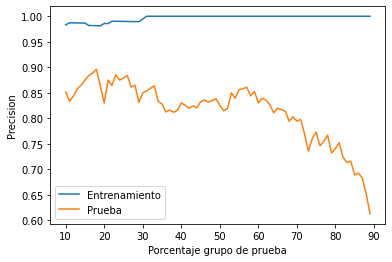

In [ ]:
y_test_tmp = []
y_train_tmp = []
for i in range(10, 90):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=i / 100, random_state=30)
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    y_train_tmp.append(logreg.score(X_train, y_train))
    y_test_tmp.append(logreg.score(X_test, y_test))

plt.plot(range(10, 90), y_train_tmp, label='Entrenamiento')
plt.plot(range(10, 90), y_test_tmp, label='Prueba')
plt.xlabel('Porcentaje grupo de prueba')
plt.ylabel('Precision')
plt.legend()
plt.show()

En este caso, vemos que la precisión varía poco entre el 20% y el 60%. Me he inclinado por un número de muestras de 33% para el conjunto de prueba y 67% para el de entrenamiento. Se puede observar que la precisión es buena, incluso para el grupo de prueba (80%).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

print("Precisión: %0.2f" % logreg.score(x, y))
print("- Entrenamiento: %0.2f" % logreg.score(X_train, y_train))
print("- Test: %0.2f" % logreg.score(X_test, y_test))

Precisión: 0.93
- Entrenamiento: 1.00
- Test: 0.80


# Otros métodos de selección de datos de entrenamiento y prueba 

También podemos utilizar otros métodos de selección de datos de entrenamiento y prueba como la validación cruzada.

In [ ]:
scores = cross_val_score(logreg, x, y)
print("- Entrenamiento + Test: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(logreg, X_train, y_train)
print("- Entrenamiento: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(logreg, X_test, y_test)
print("- Test: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))

- Entrenamiento + Test:  [0.9245283  0.83018868 0.9245283  0.8490566  0.86538462]
 --> Precisión media: 0.88
 --> Desviación estándar: 0.04
- Entrenamiento:  [0.88888889 0.82857143 0.77142857 0.82857143 0.82857143]
 --> Precisión media: 0.83
 --> Desviación estándar: 0.04
- Test:  [0.77777778 0.66666667 0.88888889 0.82352941 0.82352941]
 --> Precisión media: 0.80
 --> Desviación estándar: 0.07


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


# K-Fold

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(logreg, x, y, scoring='accuracy', cv=cv)
print("- Entrenamiento + Test: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(logreg, X_train, y_train, cv=cv)
print("- Entrenamiento: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(logreg, X_test, y_test, cv=cv)
print("- Test: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))

- Entrenamiento + Test:  [0.77777778 0.85185185 0.81481481 0.88888889 0.84615385 0.84615385
 0.92307692 0.88461538 0.84615385 0.92307692]
 --> Precisión media: 0.86
 --> Desviación estándar: 0.04
- Entrenamiento:  [0.83333333 0.83333333 0.88888889 0.66666667 0.83333333 0.72222222
 0.76470588 0.94117647 0.88235294 0.94117647]
 --> Precisión media: 0.83
 --> Desviación estándar: 0.09
- Test:  [0.77777778 0.77777778 0.88888889 0.55555556 0.55555556 0.77777778
 0.77777778 0.88888889 0.875      0.75      ]
 --> Precisión media: 0.76
 --> Desviación estándar: 0.11


# Leave One Out

In [ ]:
cv = LeaveOneOut()
scores = cross_val_score(logreg, x, y, scoring='accuracy', cv=cv)
print("- Entrenamiento + Test: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(logreg, X_train, y_train, cv=cv)
print("- Entrenamiento: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))
scores = cross_val_score(logreg, X_test, y_test, cv=cv)
print("- Test: ", scores)
print(" --> Precisión media: %0.2f\n --> Desviación estándar: %0.2f" % (scores.mean(), scores.std()))

- Entrenamiento + Test:  [1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 --> Precisión media: 0.87
 --> Desviación estándar: 0.33
- Entrenamiento:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 

He variado el número de divisiones (splits) utilizadas, pero aunque los resultados no son malos, nunca son mejores que sin la validación cruzada. Por lo tanto, trabajaré sin validación cruzada.

# Representación gráfica

La representación gráfica de las probabilidades de pertenencia a cada clase muestra que por encima de una probabilidad de 0.6, el clasificador es casi 100% fiable. Por otra parte, se puede observar que los errores se producen a menudo para probabilidades relativamente bajas, lo que demuestra que el clasificador no esta
seguro de sus resultados en estos casos.

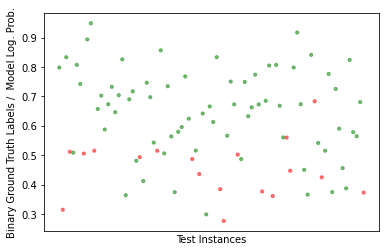

In [ ]:
log_output = logreg.predict_proba(X_test)
pred_test = logreg.predict(X_test)
colors = ['Green' if i else 'Red' for i in pred_test == y_test]
log_output_bis = []
for i in range(len(log_output[:, 1])):
    log_output_bis.append(max(log_output[i, :]))

f, ax = plt.subplots(sharey=True)
plt.setp(ax, xticks=[])
ax.scatter(range(0, len(log_output_bis), 1), log_output_bis, s=10, label='Log Prob.', c=colors, alpha=0.5)
ax.set_xlabel('Test Instances')
ax.set_ylabel('Binary Ground Truth Labels /  Model Log. Prob.')
plt.show()

Al calcular la matriz de confusión y al analyzar, vemos una cosa interesante. Podemos ver que el clasificador tiene dificultades para diferenciar a los jugadores de la clase 0 y los de la clase 8. Con un pequeño análisis del archivo csv, podemos entender rápidamente porqué. Los jugadores de estos dos grupos son relativamente similares (grupo 1: Yaya Toure, Arturo Vidal, Gabi, Marco Verratti, Luka Modric, Toni Kroos, grupo 2: Gotze, Robben, Di Maria, Ozil, De Bruyne, Fabregas), son centrocampistas técnicos, que realizan muchos pases precisos y decisivos.

In [ ]:
pred = logreg.predict(x)
cm = confusion_matrix(y, pred)

print(cm)
print('')
print(classification_report(y, pred, target_names=['class 0', 'class 1',
                                                   'class 2', 'class 3',
                                                   'class 4', 'class 5',
                                                   'class 6', 'class 7',
                                                   'class 8']))

[[21  0  0  0  0  0  0  1  5]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0]
 [ 1  0  0 49  0  0  0  1  0]
 [ 0  0  0  1 33  0  0  0  2]
 [ 0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0 34  1  0]
 [ 0  0  0  0  1  0  2 34  0]
 [ 2  0  0  0  0  0  1  0 26]]

              precision    recall  f1-score   support

     class 0       0.88      0.78      0.82        27
     class 1       1.00      1.00      1.00         4
     class 2       1.00      1.00      1.00        11
     class 3       0.98      0.96      0.97        51
     class 4       0.97      0.92      0.94        36
     class 5       1.00      1.00      1.00        34
     class 6       0.92      0.97      0.94        35
     class 7       0.92      0.92      0.92        37
     class 8       0.79      0.90      0.84        29

    accuracy                           0.93       264
   macro avg       0.94      0.94      0.94       264
weighted avg       0.93      0.93      0.93       264



# ROC

También he trazado las curvas ROC. Como tengo un modelo multiclase, lo he reducido a un modelo binario utilizando el método de One vs Rest. Sin embargo, he trabajado en las mismas muestras (X_train, X_test, y_train e y_test) que para el primer modelo para poder relacionar los resultados obtenidos con los de la primera parte.

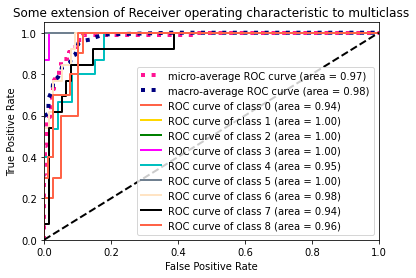

In [ ]:
# Binarize the output
y_train = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

n_classes = y_train.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')).fit(X_train, y_train)

y_score = classifier.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["tomato", "gold", "g", "magenta", "c", "slategray", "bisque", "k"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

Vemos aquí que obtenemos muy buenos resultados con áreas cercanas a 1 a pesar del pequeño número de muestras para entrenar el modelo y para probarlo. 

Esta curva permite visualizar qué tasa de falsos positivos podemos aceptar guardando resultados satisfactorios y esto para cada clase. Esta elección es necesariamente subjetiva pero aquí yo diría que el 10% de falsos positivos es un buen compromiso. Tenemos todos los verdaderos positivos excepto unos pocos (10%) de las clases 4 y 7.

# Importancia de la cantidad de datos para entrenar el modelo

Aunque los resultados obtenidos fueron buenos, pensé que uno de los problemas que reducía su precisión era el bajo número de muestras en cada clase. De hecho, con 264 muestras para 9 clases, si tomamos el 67% para el conjunto de entrenamiento. Esto hace una media de 20 muestras para entrenar cada clase lo que ya es poco. Pero algunas clases son más extensas que otras y como la función train_test_split es perfectamente aleatoria, es posible que tome más muestras de una clase que de otra. Todo esto significa que algunas clases solo se han entrenado en unas pocas muestras, tal vez 4 o 5. 

Para comprobar mi intuición, creé un archivo de tres clases con mi clustering (k_means_3_clusters.csv). Por lo tanto, la cantidad de jugadores en cada clase es mucho mayor y el modelo tiene más datos para entrenar.

In [ ]:
df = pd.read_csv('k_means_3_clusters.csv', index_col='name')

print(df.head())

x = df.drop('cluster', axis=1)
y = df.loc[:, 'cluster']

print(y.head())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

print("Precisión: %0.2f" % logreg.score(x, y))
print("- Entrenamiento: %0.2f" % logreg.score(X_train, y_train))
print("- Test: %0.2f\n" % logreg.score(X_test, y_test))

pred = logreg.predict(x)
cm = confusion_matrix(y, pred)

print('Confusion matrix: \n')
print(cm)
print('')
print(classification_report(y, pred, target_names=['class 0', 'class 1',
                                                   'class 2']))

                     goals  bigChancesCreated  bigChancesMissed   assists  \
name                                                                        
Yaya Touré       -0.423817          -0.052154         -0.283263  1.055707   
Radja Nainggolan -0.105115           0.418275         -0.461116  0.206267   
Marlos           -0.188627           0.126060         -0.722721  0.614879   
Eduardo Salvio    0.140904           0.905385         -0.372251  0.630694   
Jesús Corona      0.452101          -0.635115         -0.375562  0.614879   

                  goalsAssistsSum  accuratePasses  inaccuratePasses  \
name                                                                  
Yaya Touré               0.140034        1.265302         -0.462732   
Radja Nainggolan         0.010754       -0.687008         -0.647279   
Marlos                   0.124896       -0.199990         -1.347503   
Eduardo Salvio           0.377014       -1.056680         -0.132762   
Jesús Corona             0.601838 

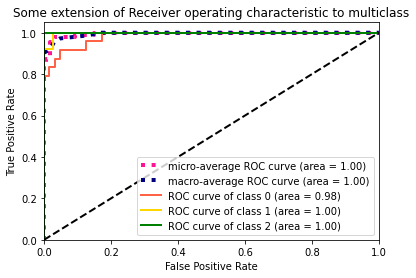

In [16]:
# Binarize the output
y_train = label_binarize(y_train, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])

n_classes = y_train.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear')).fit(X_train, y_train)

y_score = classifier.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

lw = 2
colors = cycle(["tomato", "gold", "g", "magenta", "c", "slategray", "bisque", "k"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

Los resultados confirman mi intuición y son excelentes, con una precisión del 95% en el grupo de prueba.

# Conclusión

Es posible la clasificación de jugadores de fútbol mediante un método de aprendizaje supervisado como la regresión logística. Sin embargo, para obtener resultados satisfactorios, es importante entrenar el modelo con un número suficiente de muestras.